<a href="https://colab.research.google.com/github/ROARMarketingConcepts/SugarCRM/blob/master/Marketing_Channel_Attribution_Example_Using_Markov_Chains.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Marketing Channel Attribution Example Using Markov Chains

### Markov Chains describe a sequence of possible events in which the probability of each event depends only on the state attained in the previous event. In the context of channel attribution, Markov Chains give us a framework to model user journeys and how each channel factors into the users traveling from one channel to another to eventually purchase (or not).

### The underlying concept of Markov chains is that customer journey data can be processed  to identify the probabilities of moving from one event to another in a network of potential marketing channel events and conversion events.

Performed by:

Ken Wood

Marketing Data Scientist

SugarCRM

kwood@sugarcrm.com

(919) 802-0065



### Mount the Google Drive where the data files are located.

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Load the necessary Python software packages to perform the attribution analysis...

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import subprocess
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

### Load the 'Channel_attribution.csv' file from location *''/content/drive/My Drive/Colab Notebooks/Marketing Attribution - Markov Chains/'* and develop some summary statistics.



In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Marketing Attribution - Markov Chains/Channel_attribution.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 21 columns):
R05A.01    2392 non-null int64
R05A.02    2392 non-null int64
R05A.03    2384 non-null float64
R05A.04    2217 non-null float64
R05A.05    1586 non-null float64
R05A.06    1030 non-null float64
R05A.07    605 non-null float64
R05A.08    391 non-null float64
R05A.09    228 non-null float64
R05A.10    138 non-null float64
R05A.11    82 non-null float64
R05A.12    52 non-null float64
R05A.13    29 non-null float64
R05A.14    19 non-null float64
R05A.15    8 non-null float64
R05A.16    7 non-null float64
R05A.17    4 non-null float64
R05A.18    2 non-null float64
R05A.19    1 non-null float64
R05A.20    1 non-null float64
Output     0 non-null float64
dtypes: float64(19), int64(2)
memory usage: 392.5 KB


### Let's examine 'Channel_attribution.csv'...

In [0]:
print("Shape of dataframe: ",df.shape,"\n")             # Get shape of dataframe.
print(df.head())                                        # Print first 5 rows of dataframe.
print(df.describe())                                    # Get some summary stats on the dataframe variables

Shape of dataframe:  (2392, 21) 

   R05A.01  R05A.02  R05A.03  R05A.04  ...  R05A.18  R05A.19  R05A.20  Output
0       16        4      3.0      5.0  ...      NaN      NaN      NaN     NaN
1        2        1      9.0     10.0  ...      NaN      NaN      NaN     NaN
2        9       13     20.0     16.0  ...      NaN      NaN      NaN     NaN
3        8       15     20.0     21.0  ...      NaN      NaN      NaN     NaN
4       16        9     13.0     20.0  ...      NaN      NaN      NaN     NaN

[5 rows x 21 columns]
           R05A.01      R05A.02      R05A.03  ...  R05A.19  R05A.20  Output
count  2392.000000  2392.000000  2384.000000  ...      1.0      1.0     0.0
mean      8.391722     9.291388    12.304530  ...     20.0     21.0     NaN
std       4.462116     5.375250     6.524588  ...      NaN      NaN     NaN
min       1.000000     1.000000     1.000000  ...     20.0     21.0     NaN
25%       4.000000     4.000000     6.000000  ...     20.0     21.0     NaN
50%      10.000000 

### Get a list of columns in df and convert all variables to type 'str'. Also, remove any trailing '.0'

In [0]:
cols = df.columns  

for col in cols:
  df[col] = df[col].astype(str)
  df[col] = df[col].map(lambda x: str(x)[:-2] if '.' in x else str(x))

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 21 columns):
R05A.01    2392 non-null object
R05A.02    2392 non-null object
R05A.03    2392 non-null object
R05A.04    2392 non-null object
R05A.05    2392 non-null object
R05A.06    2392 non-null object
R05A.07    2392 non-null object
R05A.08    2392 non-null object
R05A.09    2392 non-null object
R05A.10    2392 non-null object
R05A.11    2392 non-null object
R05A.12    2392 non-null object
R05A.13    2392 non-null object
R05A.14    2392 non-null object
R05A.15    2392 non-null object
R05A.16    2392 non-null object
R05A.17    2392 non-null object
R05A.18    2392 non-null object
R05A.19    2392 non-null object
R05A.20    2392 non-null object
Output     2392 non-null object
dtypes: object(21)
memory usage: 392.5+ KB


### We now create the Markov chain framework where user journeys are combined into a single variable of the form 'Channel 1 > Channel 2 > Channel 3 > ...' 

In [0]:
df['Path'] = ''  # First we create the 'Path' variable.

for i in df.index:
    #df.at[i, 'Path'] = 'Start'
    for x in cols:
        df.at[i, 'Path'] = df.at[i, 'Path'] + df.at[i, x] + ' > '

In [0]:
df['Path'].head()

0    16 > 4 > 3 > 5 > 10 > 8 > 6 > 8 > 13 > 20 > 21...
1    2 > 1 > 9 > 10 > 1 > 4 > 3 > 21 > nan > nan > ...
2    9 > 13 > 20 > 16 > 15 > 21 > nan > nan > nan >...
3    8 > 15 > 20 > 21 > nan > nan > nan > nan > nan...
4    16 > 9 > 13 > 20 > 21 > nan > nan > nan > nan ...
Name: Path, dtype: object

### Since Channel 21 in our dataset is a conversion event, we will separate that channel from the path and create a separate conversion variable holding the number of conversions happening (still only 1 in our user journey level data)




In [0]:
# Split path on conversion (channel 21)
df['Path'] = df['Path'].map(lambda x: x.split(' > 21')[0])

# Create conversion value we can sum to get total conversions for each path
df['Conversion'] = 1

In [0]:
df.head()

,R05A.01,R05A.02,R05A.03,R05A.04,R05A.05,R05A.06,R05A.07,R05A.08,R05A.09,R05A.10,R05A.11,R05A.12,R05A.13,R05A.14,R05A.15,R05A.16,R05A.17,R05A.18,R05A.19,R05A.20,Output,Path,Conversion
0,16,4,3,5,10,8,6,8,13,20,21,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,16 > 4 > 3 > 5 > 10 > 8 > 6 > 8 > 13 > 20,1
1,2,1,9,10,1,4,3,21,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2 > 1 > 9 > 10 > 1 > 4 > 3,1
2,9,13,20,16,15,21,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,9 > 13 > 20 > 16 > 15,1
3,8,15,20,21,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,8 > 15 > 20,1
4,16,9,13,20,21,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,16 > 9 > 13 > 20,1


### We’re now almost done with the initial data manipulation work. Our data still contains all the original columns, so we select the subset of columns that we need going forward. Since some users may have taken the same journey, we will group our data by unique user journeys and our conversion variable will hold the number of conversions for each respective journey.

In [0]:
# Select relevant columns
df = df[['Path', 'Conversion']]

# Sum conversions by Path
df = df.groupby('Path').sum().reset_index()

# Write DF to CSV to be executed in R
df.to_csv('/content/drive/My Drive/Colab Notebooks/Marketing Attribution - Markov Chains/Paths.csv', index=False)

### The last line in the above piece of code will output our data to a .csv file now that we’re done with the data manipulations. It might be handy to have this data available for transparency purposes, and, in our case, we will also use this .csv file to run the Markov chain attribution approach.

### *   We will leverage the ChannelAttribution R library which has the theory behind Markov chains built into a single application.
### *   We will run the R script below in R Studio and then return to Python to process the output files provided by the attribution analysis.



### Load the Channel Attribution Package in R

if(!require(ChannelAttribution)){
  install.packages("ChannelAttribution")
  library(ChannelAttribution)
}

### Set Working Directory
setwd <- setwd('/content/drive/My Drive/Colab Notebooks/Marketing Attribution - Markov Chains')

### Read in our CSV file outputed by the Python script
df <- read.csv('Paths.csv')

### Select only the necessary columns
df <- df[c(1,2)]

### Run the Markov Model function
M <- markov_model(df, 'Path', var_value = 'Conversion', var_conv = 'Conversion', sep = '>', order=1, out_more = TRUE)

### Export the Markov model output to a csv file, to be read back into Python
write.csv(M$result, file = "Markov - Output - Conversion values.csv", row.names=FALSE)

### Output the transition matrix as well, for visualization purposes
write.csv(M$transition_matrix, file = "Markov - Output - Transition matrix.csv", row.names=FALSE)

In [0]:
# Load in the CSV file with the model output from R
markov = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Marketing Attribution - Markov Chains/Markov - Output - Conversion values.csv')

# Select only the necessary columns and rename them
markov = markov[['channel_name', 'total_conversions']]
markov.columns = ['Channel', 'Conversion']
markov.head()

,Channel,Conversion
0,1,82.314244
1,20,433.220946
2,12,84.259249
3,14,63.511743
4,13,195.942072


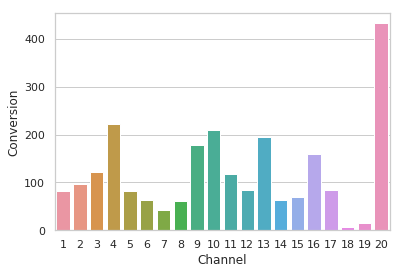

In [0]:
ax = sns.barplot(x="Channel", y="Conversion", data=markov)